# Modelo preditivo
***

Neste dataset, o objetivo é prever o valor da mediana dos preços da casa na área de California. As features coletadas se baseam no estado real e informação geográfica.

Como o objetivo é prever um valor contínuo, esta tarefa é de regressão.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Para facilitar futura visualização, vamos transformar os preços de dólar($) para (k$).

In [4]:
target *= 100
target.head() # rescale the target in k$

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Erro de treinamento vs erro de teste.

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display='diagram')

tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(data, target)

DecisionTreeRegressor(random_state=0)

Depois de treinar o modelo, queremos avaliar a performance estatística antes de colocar o modelo em produção. Para isso vamos usar a métrica **mean absolute error**, que nos dá o erro na unidade nativa do variável target, que aqui será (k$).
*erro médio absoluto expressa o erro de previsão médio absoluto do modelo. Se quisermos ignorar os outliers, é uma boa métrica para ser usada.

In [6]:
from sklearn.metrics import mean_absolute_error

target_predicted = tree_reg.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"Na média, nosso regressor erra por {score:.2f} k$")

Na média, nosso regressor erra por 0.00 k$


O erro computado acima é chamado de erro empirico ou erro de treinamento.

Nos treinamos um modelo preditivo para minimizar o erro de treinamento, mas nosso objetivo é minimizar o erro nos dados não vistos na etapa de treinamento.

Esse erro é chamado de erro de generalização ou "true" **erro de teste**.

### Avaliação de modelo envolve(steps):
***

* dividir o dataset em 2 subsets: conj. treinamento e conj. teste
* treinar o modelo no conjunto de treinamento.
* estimação do erro de treinamento calculado no conjunto de treinamento.
* estimação do erro de teste calculado no conjunto de teste

Dividir os dados em treinamento e teste:

In [7]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state = 0)

In [8]:
tree_reg.fit(data_train, target_train)
tree_reg

DecisionTreeRegressor(random_state=0)

In [9]:
target_predicted = tree_reg.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"O erro de treinamento do nosso modelo é: {score:.2f} k$")

O erro de treinamento do nosso modelo é: 0.00 k$


Observamos a mesma solução anterior, o que indica que nosso modelo memorizou os dados. Vamos computar o erro de teste para ver o que obtemos.

In [10]:
target_predicted = tree_reg.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"O erro de teste do nosso modelo é: {score:.2f} k$")

O erro de teste do nosso modelo é: 47.28 k$


O erro com respeito ao conjunto de teste é o que esperaríamos do nosso modelo em um ambiente de produção.

### Estabilidade da validação cruzada
***

Quando executamos uma simples divisão train-test nós não temos nenhuma indicação com respeito a robustez da avaliação do nosso modelo preditivo: em particular, se o conjunto de teste é pequeno, a estimação do erro de teste será instável e não refletirá a verdadeira taxa de erro que poderia ser observado com o mesmo modelo em uma quantidade ilimitada de dados para teste.

Ou poderíamos ter sorte e na nossa divisão aleatória do nosso dataset limitado, e conseguirmos somente casos simples para prever no conjunto de teste, apenas por chance. A estimação do erro não refletiria  a realidade e seria otimista.

**Cross-validation** permitir estimar a robustez do modelo preditivo repetindo o procedimento de divisão. Isso daria muitos conjuntos de treinamento/teste para avaliar os erros associados e então teríamos como estimar a variabilidade da performance estatística do nosso modelo.

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    tree_reg, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [12]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.172456,0.004499,-46.909797
1,0.189371,0.005185,-46.421170
2,0.181118,0.006346,-47.411089
3,0.165489,0.004512,-44.319824
4,0.162273,0.004683,-47.607875


Uma pontuação(score) é uma métrica para a qual valores mais altos significam melhores resultados. Pelo contrário, um erro é uma métrica para a qual valores mais baixos significam melhores resultados. A pontuação de parâmetro em cross_validate sempre espera uma função que seja uma pontuação.

Para facilitar, todas as métricas de erro no scikit-learn, como mean_absolute_error, podem ser transformadas em uma pontuação a ser usada em cross_validate. Para fazer isso, você precisa passar uma string da métrica de erro com uma string neg_ adicional na frente para a pontuação do parâmetro; por exemplo scoring = "neg_mean_absolute_error". Neste caso, o negativo do erro absoluto médio será calculado, o que seria equivalente a uma pontuação.

Vamos reverter a negação para pegar o erro atual.

In [13]:
cv_results['test_error'] = -cv_results['test_score']
cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.172456,0.004499,-46.909797,46.909797
1,0.189371,0.005185,-46.421170,46.421170
2,0.181118,0.006346,-47.411089,47.411089
3,0.165489,0.004512,-44.319824,44.319824
4,0.162273,0.004683,-47.607875,47.607875


Nós podemos ler no dataframe acima, o tempo de treinamento de cada fold, predição de cada iteração da validação cruzada. Como também podemos pegar o score de teste que corresponde ao erro de teste em cada fold.

Podemos usar os folds da validação cruzada para olhar os erros de teste e através da análise visual da sua distribuição estimar a variabilidade.


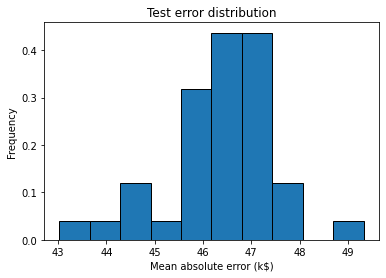

In [14]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

Podemos observar que o erro no conjunto de teste é centralizado ao redor de $47 k$ USD e varia entre 43 k$ a 50 k$.

In [15]:
print(f"A média do erro de teste na validação cruzada é: {cv_results['test_error'].mean():.2f} k$")

A média do erro de teste na validação cruzada é: 46.36 k$


In [16]:
print(f"O desvio padrão do erro de teste é: {cv_results['test_error'].std():.2f} k$")

O desvio padrão do erro de teste é: 1.17 k$


Podemos notar que o desvio padrão do erro de teste é bem menor que a média do erro. Poderíamos comparar o erro de teste com a variabilidade natural do nosso target do dataset.

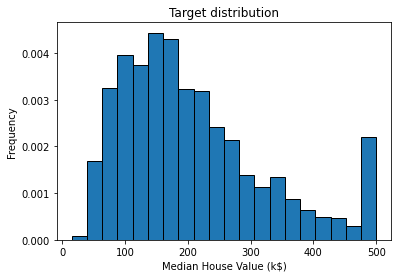

In [17]:
target.plot.hist(bins=20, edgecolor="black", density=True)
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [18]:
print(f"O desvio padrão do target é :{target.std():.2f} k$")

O desvio padrão do target é :115.40 k$


Considerando o erro a média do erro obtido com validação cruzada que foi de $47 k$ USD, não é um problema qdo estivermos prevendo casas no valor de 500 k$, mas é um problema qdo o valor da casa é de 50 k$, o que nos indica que o erro médio absoluto não é a métrica ideal para esse problema. Podemos usar uma métrica relativa o valor do target da previsão, mean absolute percentage error seria uma melhor escolha.

De qualquer maneira um erro de 47 k$ é muito grande para que usemos o nosso modelo para prever os valores dos preços das casas sem a supervisão de um expert do assunto.

In [19]:
cv_results = cross_validate(tree_reg, data, target, return_estimator=True)
cv_results

{'fit_time': array([0.21163654, 0.20255828, 0.25834179, 0.22371149, 0.19612169]),
 'score_time': array([0.00467706, 0.00496078, 0.00698471, 0.00567222, 0.00409794]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

In [20]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

Ter acesso aos regressores é útil porque permite a inspeção dos valores internos do fit destes regressores.

In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])

In [22]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [23]:
target[:5]

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
data.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

In [26]:
linear_model = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
linear_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [27]:
print(f"Pipeline steps:\n{linear_model.steps}")

Pipeline steps:
[('standardscaler', StandardScaler()), ('linearregression', LinearRegression())]


In [28]:
_ = linear_model.fit(data_train, target_train)

In [29]:
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    linear_model, data, target, cv=cv, scoring="neg_mean_squared_error")

In [30]:
# Pontuação nos conjuntos de teste dos splits
cv_results = pd.DataFrame(cv_results)
cv_results.head(10)

,fit_time,score_time,test_score
0,0.017811,0.007504,-5431.489670
1,0.023667,0.017109,-5379.547943
2,0.041494,0.009154,-5458.188203
3,0.024108,0.005605,-4922.420431
4,0.029120,0.005716,-5219.908777
5,0.020874,0.006199,-5258.556051
6,0.027005,0.005745,-5335.972492
7,0.023055,0.005682,-5232.386115
8,0.025338,0.005787,-5257.945324
9,0.020319,0.005684,-5630.336054


In [31]:
cv_results['test_error'] = -cv_results['test_score']
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.017811,0.007504,-5431.489670,5431.489670
1,0.023667,0.017109,-5379.547943,5379.547943
2,0.041494,0.009154,-5458.188203,5458.188203
3,0.024108,0.005605,-4922.420431,4922.420431
4,0.029120,0.005716,-5219.908777,5219.908777
5,0.020874,0.006199,-5258.556051,5258.556051
6,0.027005,0.005745,-5335.972492,5335.972492
7,0.023055,0.005682,-5232.386115,5232.386115
8,0.025338,0.005787,-5257.945324,5257.945324
9,0.020319,0.005684,-5630.336054,5630.336054


In [32]:
print(f"A média do erro no conjunto de teste usando validação cruzado do modelo linear é:\
      \n{cv_results['test_error'].mean():.3f} +/- {cv_results['test_error'].std():.3f} k$")

A média do erro no conjunto de teste usando validação cruzado do modelo linear é:      
5300.185 +/- 149.455 k$


In [33]:
print(f"O total de features no dataset analisado : {data.shape[1]}")

O total de features no dataset analisado : 8


In [34]:
print(f"Pipeline steps:\n{linear_model.steps}")

Pipeline steps:
[('standardscaler', StandardScaler()), ('linearregression', LinearRegression())]


In [36]:
coeficientes = linear_model.named_steps['linearregression'].coef_
print(f"Os pesos das características(coeficientes) da regressão linear do modelo são: \n{coeficientes}")

Os pesos das características(coeficientes) da regressão linear do modelo são: 
[ 83.18994482  12.09374001 -26.17515663  30.40521224  -0.87355926
  -2.98444244 -89.23653827 -86.38503112]


In [35]:
linear_model.named_steps['linearregression'].coef_.shape

(8,)

In [37]:
valor_medio_esperado = linear_model.named_steps['linearregression'].intercept_

In [38]:
print(f"O valor médio do target usando a regressão linear ou a interseção com o eixo Y é: \
    {valor_medio_esperado:.2f} k$")

O valor médio do target usando a regressão linear ou a interseção com o eixo Y é:     207.44 k$


In [39]:
r2_test = linear_model.score(data_test, target_test)
print(f"O score do conj. de teste usando estimador linear é: {r2_test:.3f}")

O score do conj. de teste usando estimador linear é: 0.591


In [40]:
r2_test_tree = tree_reg.score(data_test, target_test)
print(f"O score do conj. de teste usando estimador de decision tree é: {r2_test_tree:.3f}")

O score do conj. de teste usando estimador de decision tree é: 0.584


Os coeficientes de regressão vistos individualmente como atributos do pipeline, explicam o valor esperado(model.intercept_) e como os atributos (pesos) que causam impacto na predição. Um coeficiente positivo indica que, à medida que o valor de um atributo aumenta, o mesmo ocorrerá com a predição.

Para melhor entender a performance estatística dos nosso modelos e achar insights de como melhora-lo, nós iremos comparar os erros de treinamento com os erros de teste. Para isso vamos computar o erro de treinamento usando a função de validação cruzada(**cross_validate()**)

In [41]:
# Decision tree
tree_reg=DecisionTreeRegressor(random_state=0)
cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results_tree = cross_validate(tree_reg, data, target,
                            cv=cv, scoring="neg_mean_squared_error", # RMSE
                            return_train_score=True, n_jobs=-1)
cv_results_tree = pd.DataFrame(cv_results_tree)

A validação cruzada usa o valor negativo da erro quadrático médio (**neg_mean_squared_error**). Nós transformamos o RMSE negativo em RMSE positivo, fazendo:

In [42]:
scores_tree = pd.DataFrame()
scores_tree[['train error', "test error"]] = -cv_results_tree[['train_score', "test_score"]]

scores_tree.head(10)

,train error,test error
0,1.386908e-26,4743.505181
1,7.066237e-27,4816.093195
2,1.375989e-26,4716.884425
3,1.598073e-26,5408.813283
4,3.729783e-28,5273.501967
5,1.830627e-26,5135.527829
6,1.488528e-26,5165.479436
7,4.330541e-28,5201.633072
8,1.067176e-26,5154.875275
9,3.800230e-27,5201.396444


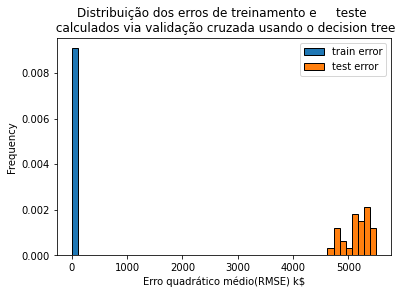

In [43]:
scores_tree.plot.hist(bins=50, edgecolor='k', density=True)
plt.xlabel("Erro quadrático médio(RMSE) k$")
_ = plt.title("Distribuição dos erros de treinamento e \
    teste \n calculados via validação cruzada usando o decision tree")

Plotando a distribuição dos erros de treinamento e teste, nós pegamos a informação se o modelo está sofrendo de "overfitting", "underfitting" ou ambos ao mesmo tempo.

No modelo de decision tree, vemos um pequeno erro de treinamento(aproximadamente zero), significando que o modelo não está sofrendo de "overfitting". É flexível o suficiente para capturar qualquer variação presente no conjunto de treinamento.

Contudo o grande erro de teste, nos diz que o modelo está sofrendo de "overfitting", ou seja, o modelo memorizou as muitas variações presentes no conjunto de treinamento que podem ser consideradas como "ruídos" e que não ajudam a generalizar para ajudar nas predições do conjunto de teste.

In [44]:
# Modelo Linear

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results_lr = cross_validate(linear_model, data, target,
                            cv=cv, scoring="neg_mean_squared_error", # RMSE
                            return_train_score=True, n_jobs=-1)
cv_results_lr = pd.DataFrame(cv_results_lr)

scores_lr = pd.DataFrame()
scores_lr[['train error', "test error"]] = -cv_results_lr[['train_score', "test_score"]]

scores_lr.head(10)

,train error,test error
0,5250.129821,5440.609957
1,5192.674332,5537.914833
2,5197.564907,5430.519004
3,5202.333126,5411.610367
4,5224.151377,5321.995619
5,5259.860720,5197.829966
6,5211.867829,5500.747255
7,5239.611263,5279.934181
8,5258.598849,5188.828318
9,5211.220239,5498.981776


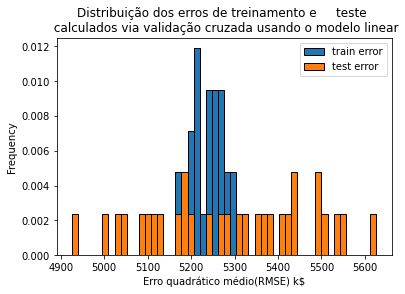

In [45]:
scores_lr.plot.hist(bins=50, edgecolor='k', density=True)
plt.xlabel("Erro quadrático médio(RMSE) k$")
_ = plt.title("Distribuição dos erros de treinamento e \
    teste \n calculados via validação cruzada usando o modelo linear")

Usando o modelo linear, percebemos que os erros de treinamento, e os erros de teste são altos, o que nos informa que esse não é um modelo que pode ser usado, o modelo sofre de overfitting e underfitting ao mesmo tempo.

### Curva de validação
Alguns hiperparâmetros de um modelo são a chave para sair de modelo que está underfitting para um modelo que overfitting, e talvez achar um bom balanço entre os dois. Nós podemos adquirir conhecimento sobre essas informações usando a curva de validação.

Para um decision tree, o parâmetro max_depth é usado para controlar o tradeoff entre o underfitting e overfitting.

In [46]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    tree_reg, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_squared_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: user 586 ms, sys: 86 ms, total: 672 ms
Wall time: 16.3 s


Text(0, 0.5, 'Erro médio quadrático(k$)')

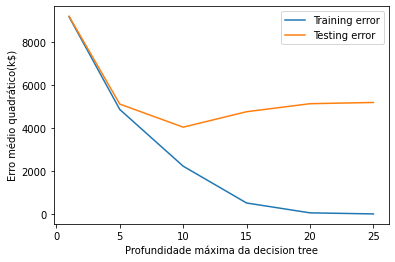

In [47]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Profundidade máxima da decision tree")
plt.ylabel("Erro médio quadrático(k$)")

Podemos dividir o gráfico em 3 áreas básicas:

* max_depth < 10, a decision tree underfits. O erro de treinamento e de teste são ambos altos. O modelo tem muitas restrições e não consegue capturar a variabilidade do variável target.
* a região em torno de max_depth = 10 corresponde ao parâmetro qual o decision tree generaliza melhor. É flexível o suficiente para capturar a fração da variabilidade do alvo, enquanto não generaliza todo o ruído do target.
* max_depth > 10, a decision tree overfita. O erro de treinamento se torna muito pequeno, enquanto o erro de teste aumenta. Nesta região o modelo cria decisões especificamente para o ruído impedindo a sua habilidade de generalização no conjunto de testes.

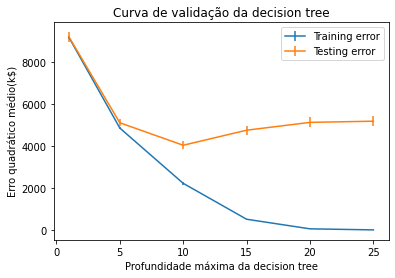

In [48]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Profundidade máxima da decision tree")
plt.ylabel("Erro quadrático médio(k$)")
_ = plt.title("Curva de validação da decision tree")

Tivemos sorte a variância dos erros são pequenos em relação aos seus respectivos valores. Portanto as conclusões anteriores são claras. O que nem sempre é o caso.

## Setar e pegar os hiperparâmetros no Scikit-Learning
***

In [49]:
model = make_pipeline(
    StandardScaler(),
    DecisionTreeRegressor(random_state=123)
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=123))])

Avaliando a performance estatística do modelo  via validação cruzada.

Podemos mudar o valor de algum  do modelo depois que modelo já tiver sido criado com método, **set_param**.

In [50]:
cv_results = cross_validate(model, data, target, scoring = 'neg_mean_squared_error')
cv_results = pd.DataFrame(cv_results)
cv_results['test_error'] = -cv_results['test_score']
cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.227175,0.003713,-8091.405884,8091.405884
1,0.184627,0.004115,-7502.472731,7502.472731
2,0.188071,0.004225,-8446.147015,8446.147015
3,0.198151,0.004346,-9453.479345,9453.479345
4,0.193767,0.004623,-8488.060473,8488.060473


In [51]:
scores = cv_results['test_error']
print(f"O RMSE via validação cruzada é:\n"
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

O RMSE via validação cruzada é:
8396.313 +/- 710.707


Criamos um modelo aonde padronizamos os dados, e em seguida usamos um estimador de árvore de decisão. Quando usamos um pipeline podemos pegar os steps da seguinte forma:

In [52]:
print(f"Pipeline steps:\n{model.steps}")

Pipeline steps:
[('standardscaler', StandardScaler()), ('decisiontreeregressor', DecisionTreeRegressor(random_state=123))]


Em geral, podemos usar o método **get_params** do scikit-learn para listar todos os parâmetros em cada passo e seus respectivos valores. Para listar todos os parâmetros que existem no pipeline criado, façamos:

In [53]:
for parameter in model.get_params():
    print(parameter)

memory
steps
verbose
standardscaler
decisiontreeregressor
standardscaler__copy
standardscaler__with_mean
standardscaler__with_std
decisiontreeregressor__ccp_alpha
decisiontreeregressor__criterion
decisiontreeregressor__max_depth
decisiontreeregressor__max_features
decisiontreeregressor__max_leaf_nodes
decisiontreeregressor__min_impurity_decrease
decisiontreeregressor__min_impurity_split
decisiontreeregressor__min_samples_leaf
decisiontreeregressor__min_samples_split
decisiontreeregressor__min_weight_fraction_leaf
decisiontreeregressor__random_state
decisiontreeregressor__splitter


**.get_params()** retorna um dicionário aonde as chaves são os nomes dos parâmetros e os valores associados a cada um dos parâmetros. Para acessar um simples parâmetro, por exemplo *"decisiontreeregressor__max_depth"*, podemos usar:

In [54]:
model.set_params(decisiontreeregressor__max_depth = 10)
cv_results = cross_validate(model, data, target, scoring = 'neg_mean_squared_error')
cv_results = pd.DataFrame(cv_results)
cv_results['test_error'] = -cv_results['test_score']
scores = cv_results['test_error']
print(f"O RMSE via validação cruzada é:\n"
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

O RMSE via validação cruzada é:
6625.249 +/- 881.826


In [55]:
max_depth_value = model.get_params()['decisiontreeregressor__max_depth']
print(f"O valor default do max_depth no pipeline criado é: \n {max_depth_value}")

O valor default do max_depth no pipeline criado é: 
 10


In [56]:
for max_depth in [None, 1, 5, 10, 50, 100]:
    model.set_params(decisiontreeregressor__max_depth = max_depth)
    cv_results = cross_validate(model, data, target, scoring = 'neg_mean_squared_error')
    cv_results = pd.DataFrame(cv_results)
    cv_results['test_error'] = -cv_results['test_score']
    scores = cv_results['test_error']
    print(f"O RMSE via validação cruzada com max_depth = {max_depth}:\n"
          f"{scores.mean():.3f} +/- {scores.std():.3f}")

O RMSE via validação cruzada com max_depth = None:
8396.313 +/- 710.707
O RMSE via validação cruzada com max_depth = 1:
9547.850 +/- 827.611
O RMSE via validação cruzada com max_depth = 5:
6658.528 +/- 1026.323
O RMSE via validação cruzada com max_depth = 10:
6625.249 +/- 881.826
O RMSE via validação cruzada com max_depth = 50:
8396.313 +/- 710.707
O RMSE via validação cruzada com max_depth = 100:
8396.313 +/- 710.707


### Warning:
***

Quando avaliamos uma família de modelos nos dados de teste e escolhemos o que performa estatisticamente melhor, nós não podemos mais confiar no score da previsão, e nós precisamos aplicar o modelo selecionado em um novo dado. Como o conjunto de teste foi usado para selecionar o modelo, este não é mais independente do modelo. Para resolver esses problemas é bom separar os dados em treino, teste e validação.

In [58]:
model = make_pipeline(
    DecisionTreeRegressor(random_state=0)
)
model

Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=0))])

In [59]:
model.steps

[('decisiontreeregressor', DecisionTreeRegressor(random_state=0))]

In [60]:
for parameter in model.get_params():
    print(parameter)

memory
steps
verbose
decisiontreeregressor
decisiontreeregressor__ccp_alpha
decisiontreeregressor__criterion
decisiontreeregressor__max_depth
decisiontreeregressor__max_features
decisiontreeregressor__max_leaf_nodes
decisiontreeregressor__min_impurity_decrease
decisiontreeregressor__min_impurity_split
decisiontreeregressor__min_samples_leaf
decisiontreeregressor__min_samples_split
decisiontreeregressor__min_weight_fraction_leaf
decisiontreeregressor__random_state
decisiontreeregressor__splitter


In [61]:
param_grid = {
    "decisiontreeregressor__max_depth": [3, 4, 5],
    "decisiontreeregressor__min_samples_leaf": [1, 2],
}

In [63]:
from  sklearn.model_selection import GridSearchCV, KFold

In [83]:
cv = KFold(n_splits = 10, shuffle=True, random_state=0)
gridsearch = GridSearchCV(
    model,
    param_grid=param_grid,
    cv = cv,
    scoring="neg_mean_absolute_error",
    n_jobs= -1,
    verbose=2.1
)
gridsearch.fit(data, target)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': [3, 4, 5],
                         'decisiontreeregressor__min_samples_leaf': [1, 2]},
             scoring='neg_mean_absolute_error', verbose=2.1)

### Visualizar os melhores hiperparâmetros:

In [67]:
best_max_depth = gridsearch.best_estimator_.get_params()["decisiontreeregressor__max_depth"]
print(f"Melhor max_depth: {best_max_depth}")

Melhor max_depth: 5


In [68]:
best_MSL = gridsearch.best_estimator_.get_params()['decisiontreeregressor__min_samples_leaf']
print(f"Melhor min_samples_leaf: {best_MSL}")

Melhor min_samples_leaf: 2


In [69]:
best_model = gridsearch.best_estimator_
print(f"O melhor estimador encontrado: \n{best_model}")

O melhor estimador encontrado: 
Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=2,
                                       random_state=0))])


In [70]:
print("Pipeline do gridsearch:\n", gridsearch.best_estimator_.get_params())

Pipeline do gridsearch:
 {'memory': None, 'steps': [('decisiontreeregressor', DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=0))], 'verbose': False, 'decisiontreeregressor': DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=0), 'decisiontreeregressor__ccp_alpha': 0.0, 'decisiontreeregressor__criterion': 'mse', 'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_leaf_nodes': None, 'decisiontreeregressor__min_impurity_decrease': 0.0, 'decisiontreeregressor__min_impurity_split': None, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__min_weight_fraction_leaf': 0.0, 'decisiontreeregressor__random_state': 0, 'decisiontreeregressor__splitter': 'best'}


In [73]:
cv_results = cross_validate(best_model, data, target,
                            scoring="neg_mean_absolute_error",
                            return_estimator=True, cv=cv, n_jobs=-1)



print(f"Mean absolute error on testing set: "
      f"{-cv_results['test_score'].mean():.3f} k$ +/- "
      f"{cv_results['test_score'].std():.3f}")

Mean absolute error on testing set: 52.115 k$ +/- 1.055


In [74]:
linear_regression = LinearRegression()
cv_results = cross_validate(linear_regression, data, target,
                            scoring="neg_mean_absolute_error",
                            return_estimator=True, cv=10, n_jobs=2)

print(f"Mean absolute error on testing set: "
      f"{-cv_results['test_score'].mean():.3f} k$ +/- "
      f"{cv_results['test_score'].std():.3f}")

Mean absolute error on testing set: 54.452 k$ +/- 9.109


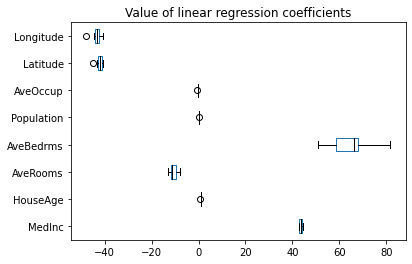

In [75]:
import matplotlib.pyplot as plt

import pandas as pd

weights = pd.DataFrame(
    [est.coef_ for est in cv_results["estimator"]], columns=data.columns)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights.plot.box(color=color, vert=False)
_ = plt.title("Value of linear regression coefficients")

In [77]:
print(f"Os melhores parâmetros encontrados: \n{gridsearch.best_params_}")

Os melhores parâmetros encontrados: 
{'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 2}


In [82]:
print(f"O melhor erro (menor média absoluta dos erros calculados) - MAE = {-gridsearch.best_score_: .2f} k$")

O melhor erro (menor média absoluta dos erros calculados) - MAE =  52.49 k$


O que CV significa no método **GridSearchCV** ?

* cross-validation: a generalização da performance para cada conjunto de parâmetros é avaliada por procedimento interno de cross-validation.

Quando chamamos fit(X, y) no grid-search, X e y, serão divididos por uma estratégia de validação cruzada interna. Por exemplo se um estratégia de validação cruzada de 10 folds for escolhida, então X e y serão divididos em 10 folds e 10 modelos serão treinados em 9 folds e testado no fold restante. Cada modelo será testado em um fold de teste diferente. E então teremos um score médio com todos os scores dos 10 modelos criados.

Esta operação é repetida para todas as combinações de valores de hiperparâmetros com a melhor média do score da validação cruzada ao final selecionada.

## Efeitos da regularização
***

In [84]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [85]:
target[:5]

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

Nós vimos que usando **PolynomialFeatures** podemos criar features adicionais que relacionem as relações não lineares entre as features.

Vamos usar essa transformação para aumentar o espaço das features. E depois treinar um modelo de regressão linear. E usar o conjunto de teste "out-of-sample" para avaliar as capacidades de generalização do nosso modelo.

In [86]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(PolynomialFeatures(degree=2),
                                  LinearRegression())
cv_results = cross_validate(linear_regression, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

Nós compararemos o MSE do conjunto de treinamento com conjunto de teste, para acessar a generalização da performance estatística do nosso modelo.

In [87]:
train_error = -cv_results["train_score"]
print(f"Mean squared error do modelo de regressão linear no conjunto de treinamento:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error do modelo de regressão linear no conjunto de treinamento:
4190.212 +/- 151.123


In [88]:
test_error = -cv_results["test_score"]
print(f"Mean squared error do modelo de regressão linear no conjunto de teste:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error do modelo de regressão linear no conjunto de teste:
13334.943 +/- 20292.681


O score no conjunto de treino é muito melhor do que no conjunto de teste. O gap na performance estatística entre o conjunto de treinamento e o conjunto de teste é um indicador de que o nosso modelo está sobreajustando no conjunto de treinamento.

Isto é um dos perigos de se aumentar o número de features com o transformador **PolynomialFeatures**. O modelo irá focar em features específicas. Podemos checar os pesos dos coeficientes do modelo para ter uma confirmação. Vamos criar um dataframe: as colunas irão conter o nome das features, enquanto as linhas terão os valores dos coeficientes gravados de cada modelo durante a validação cruzada.

Como usamos **PolynomialFeatures** para aumentar os dados, nós criaremos nomes representativos das combinações das features. O scikit-learn fornece um método chamado, get_feature_names para este propósito

In [89]:
# Pegando o primeiro modelo ajustado

model_first_fold = cv_results['estimator'][0]

Agora, podemos acessar o **PolynomialFeatures** ajustado para gerar o nome das features.

In [90]:
feature_names = model_first_fold[0].get_feature_names(
    input_features=data.columns
)
feature_names

['1',
 'MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'MedInc^2',
 'MedInc HouseAge',
 'MedInc AveRooms',
 'MedInc AveBedrms',
 'MedInc Population',
 'MedInc AveOccup',
 'MedInc Latitude',
 'MedInc Longitude',
 'HouseAge^2',
 'HouseAge AveRooms',
 'HouseAge AveBedrms',
 'HouseAge Population',
 'HouseAge AveOccup',
 'HouseAge Latitude',
 'HouseAge Longitude',
 'AveRooms^2',
 'AveRooms AveBedrms',
 'AveRooms Population',
 'AveRooms AveOccup',
 'AveRooms Latitude',
 'AveRooms Longitude',
 'AveBedrms^2',
 'AveBedrms Population',
 'AveBedrms AveOccup',
 'AveBedrms Latitude',
 'AveBedrms Longitude',
 'Population^2',
 'Population AveOccup',
 'Population Latitude',
 'Population Longitude',
 'AveOccup^2',
 'AveOccup Latitude',
 'AveOccup Longitude',
 'Latitude^2',
 'Latitude Longitude',
 'Longitude^2']

In [91]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns=feature_names)
weights_linear_regression.head()

,1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc^2,...,Population^2,Population AveOccup,Population Latitude,Population Longitude,AveOccup^2,AveOccup Latitude,AveOccup Longitude,Latitude^2,Latitude Longitude,Longitude^2
0,0.000020,-1140.478054,-98.735398,738.891253,-3694.264359,0.026004,119.975984,797.604954,602.115766,-3.350467,...,2.723361e-07,0.001898,0.002020,0.001252,0.009463,2.124956,1.801719,5.105701,9.521863,3.843453
1,0.000008,-1052.152449,-86.839210,634.802992,-3400.011303,-0.018349,279.105936,793.917970,405.165061,-3.177069,...,2.902982e-07,0.001441,0.001231,0.000569,0.015912,3.987531,3.653011,4.869199,9.361477,3.007598
2,0.000005,-1047.784035,-81.454227,566.113345,-2807.775321,0.040838,110.895680,964.710027,805.906156,-2.622063,...,3.059138e-07,0.001709,0.002302,0.001462,0.008302,1.967116,1.658570,6.592902,11.868451,5.076783
3,0.000005,-1191.834862,-91.891840,608.442796,-2977.418769,0.029125,125.399166,848.204538,541.626682,-3.221603,...,2.939819e-07,0.001828,0.002244,0.001362,0.008057,2.094999,1.815240,6.317023,10.662395,3.758923
4,0.000006,-1068.457290,-77.972734,742.832117,-3570.586800,0.060562,18.297959,985.426360,781.002570,-2.857276,...,-1.065782e-07,0.004502,0.002481,0.001733,0.002640,2.191904,0.839418,6.439938,11.955237,4.978589


Agora vamos montar um boxplot pra ver as variações dos coeficientes.

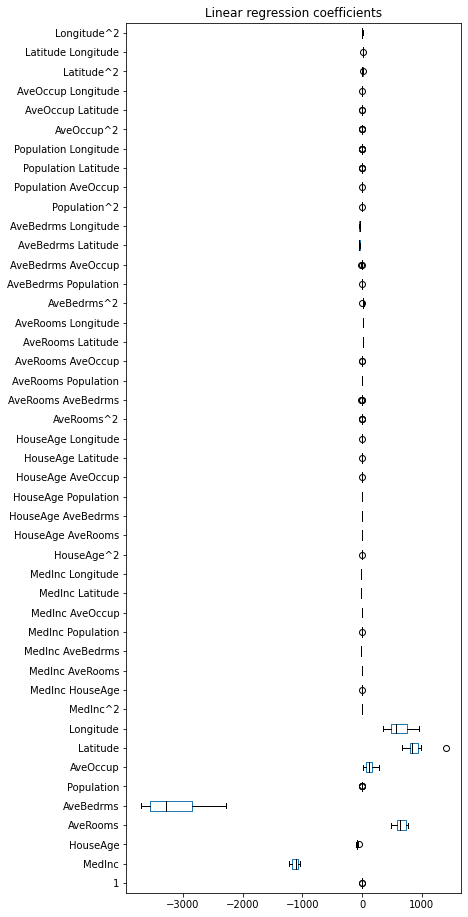

In [92]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_linear_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Linear regression coefficients")

Podemos forçar os coeficientes da regressão linear serem considerados de maneira mais homogenea. De fato, nós podemos forçar os pesos grandes positivos ou negativos serem reduzidos diretamente para zero. Isto é conhecido como regularização. Nós iremos usar o modelo ridge que força esse comportamento. Quando usamos modelos regularizados, devemos processar os dados numéricos, aplicar padronização.

A regularização adicionará restrições aos pesos do modelo.
Este procedimento deve nos fazer pensar sobre o reescalonamento de recursos. Vamos considerar o caso em que os recursos têm uma dispersão de dados idêntica: se dois recursos forem considerados igualmente importantes pelo modelo, eles serão afetados de forma semelhante pela intensidade da regularização.

Agora, vamos considerar o cenário em que os recursos têm dispersão de dados completamente diferente (por exemplo, idade em anos e receita anual em dólares). Se dois recursos forem tão importantes, nosso modelo aumentará os pesos dos recursos com pequena dispersão e reduzirá os pesos dos recursos com alta dispersão.

Lembramos que a regularização força a aproximação dos pesos. Portanto, temos a intuição de que se quisermos usar a regularização, lidar com dados reescalonados tornaria mais fácil encontrar um parâmetro de regularização ótimo e, portanto, um modelo adequado.

Como uma observação lateral, alguns solucionadores com base na computação de gradiente estão esperando esses dados redimensionados. Dados não escalonados serão prejudiciais ao calcular os pesos ideais. Portanto, ao trabalhar com um modelo linear e dados numéricos, geralmente é uma boa prática dimensionar os dados.

Assim, adicionaremos um StandardScaler no pipeline de aprendizado de máquina. Este scaler será colocado antes do regressor.

In [98]:
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(
    PolynomialFeatures(degree=2), 
    StandardScaler(),
    Ridge(alpha=0.5))

cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [99]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4347.036 +/- 156.666


In [100]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
5508.472 +/- 1816.642


In [101]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

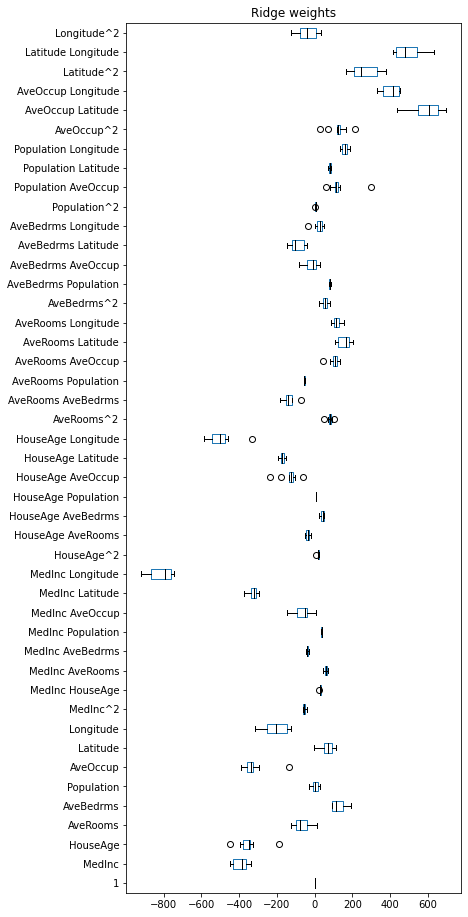

In [102]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights")

O hiperparâmetro alpha, deve ser tunado.

In [103]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))

In [104]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data, target,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)

In [105]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4306.562 +/- 25.918


In [106]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
4348.657 +/- 252.921


Otimizando o valor de alpha podemos ver que o nosso modelo não está mais sobreajustando. Pq os erros estão bem próximos como pode ver acima.

Ao ajustar o regressor ridge, também solicitamos armazenar o erro encontrado durante a validação cruzada (definindo o parâmetro store_cv_values ​​= True). Faremos um gráfico do erro quadrático médio para as diferentes forças de regularização de alfas que tentamos.

In [107]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas

,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,7587.897141,7059.531216,6579.796667,6161.839629,5813.048345,5535.350138,5326.646369,5182.950517,5100.749049,5079.212663,5122.029454,5238.704149,5445.118890,5763.012259,6217.925433,6835.274126,7634.692137,8623.620241,9791.918443,11109.476019
1,7079.341771,6696.622046,6329.022308,5987.727181,5681.306000,5415.171818,5191.880969,5012.209177,4876.780585,4787.974274,4751.851652,4779.853646,4889.937328,5106.656625,5459.549144,5979.280717,6691.530974,7609.581815,8727.609953,10017.092899
2,24857.406605,21448.284772,18293.478416,15481.009011,13067.031991,11071.457116,9480.437579,8254.431555,7338.963939,6675.026438,6207.024331,5887.541169,5679.263698,5554.913823,5496.051755,5491.367683,5534.775517,5623.398006,5755.456140,5928.154410
3,7504.216958,7125.074257,6754.172985,6400.999897,6072.937966,5774.941819,5509.955509,5280.027720,5087.960263,4939.271829,4844.228092,4819.618117,4889.808854,5086.420585,5445.877349,6004.320850,6790.113763,7815.311733,9068.542918,10511.939341
4,6999.938808,6598.898743,6215.363499,5861.328579,5546.025773,5275.377052,5052.349007,4878.140850,4753.964890,4683.117084,4673.049960,4737.162496,4895.935124,5176.863333,5612.500529,6236.037942,7074.449338,8140.303978,9424.471281,10892.352852


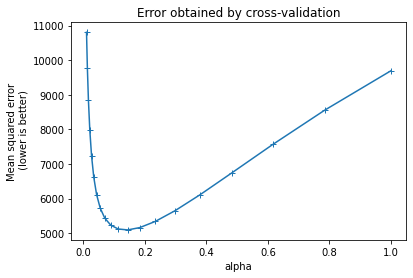

In [108]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

Como podemos ver, a regularização é como o sal no cozimento: é preciso equilibrar sua quantidade para obter o melhor desempenho estatístico. Podemos verificar se o melhor alfa encontrado é estável no fold de validação cruzada.

In [109]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

[0.08858667904100823,
 0.11288378916846889,
 0.37926901907322497,
 0.14384498882876628,
 0.11288378916846889]

### Regularização

Se refere à:

* encolhendo os pesos do modelo linear para zero
* ridge model: a mesma coisa que um modelo linear com os pesos penalizados.

Suponha que um cientista de dados tenha preparado uma divisão de treinamento / teste e planeje usar o teste para a avaliação final de um modelo Ridge. O parâmetro alfa do modelo Ridge:

* Deve ser ajustado rodando validação cruzada no conjunto de treinamento.
* Pode ser escolhido a mão usando o conhecimento a priori de um expert no problema.

Se o cientista de dados sabe que os dados não são muito ruidosos e que há um número suficiente de amostras e que as features não são altamente correlacionados, pode-se concluir que a regularização não é necessária e, portanto, alfa pode ser fixado em um valor pequeno, como 1e-10.

Um hiperparâmetro nunca deve ser escolhido no conjunto de teste: Isto superestimará o desempenho de generalização do modelo.

* Modelos que dependem da distância entre um par de amostras, por exemplo k-vizinhos mais próximos, devem ser treinados em recursos normalizados para fazer com que cada recurso contribua de forma aproximadamente igual para os cálculos de distância.
* Muitos modelos, como regressão logística, usam um solucionador numérico (com base na descida de gradiente) para encontrar seus parâmetros ideais. Este solucionador converge mais rápido quando os recursos são dimensionados.
* Preditores usando distância euclidiana, por exemplo k-vizinhos mais próximos, devem ter características normalizadas de forma que cada um contribua igualmente para o cálculo da distância;
preditores usando algoritmos baseados em gradiente descendente, por exemplo, regressão logística, para encontrar parâmetros ótimos funcionam melhor e mais rápido;
* Os preditores que usam regularização, por exemplo, regressão logística, requerem recursos normalizados para aplicar adequadamente os pesos.

O efeito de uma regularização $l2$ como é feito no ridge é :
* encolher todos os pesos para zero.